<a href="https://colab.research.google.com/github/shubhamByte/Machine-Learning/blob/main/FGSM%20attack%20on%20CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# Preparing the Dataset

In [17]:
# Transformer
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Downloading Data
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(train_data, batch_size= 128, shuffle=True, num_workers = 2)
testloader = torch.utils.data.DataLoader(test_data, batch_size= 128, shuffle=False, num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
classes = train_data.classes
print(classes)
print(train_data.class_to_idx)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [19]:
len(train_data), len(test_data), train_data[0][0].shape

(50000, 10000, torch.Size([3, 32, 32]))

### Visualise the sample data

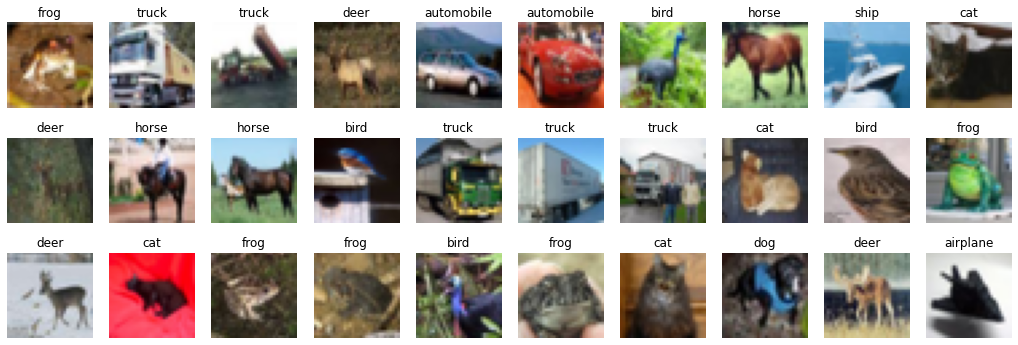

In [20]:
figure = plt.figure(figsize=(18, 6))
cols, rows = 10, 3

labelMap = { 0 :'airplane',  1 :'automobile',  2 : 'bird' ,  3 : 'cat',  4 : 'deer', 5 : 'dog',  6 : 'frog',  7 : 'horse', 8 : 'ship',  9 : 'truck'}

for i in range(cols * rows):
  img, label = train_data[i]
  figure.add_subplot(rows, cols, i + 1)     # starts from 1 that's why added 1

  plt.imshow((img.numpy().transpose(1,2,0)) * 0.5 + 0.5)
 
  plt.title(labelMap[label])
  plt.axis("off")

plt.show()


# Defining Model

### Hyperparameters

In [21]:
input_width = 32
input_height = 32
input_channels = 3
input_pixels = input_width * input_height * input_channels

n_conv1 = 32
n_conv2 = 64
n_conv3 = 64

kernelConv = 4
stride_conv = 1
kernelPool = 3

input_size_to_hidden = 3136       # 7 * 7 * 64
n_FC1 = 1024
n_FC2 = 512
n_classes = 10

learning_rate = 0.0001
num_epochs = 4


In [22]:
# CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # first convolution layer
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=n_conv1, kernel_size=kernelConv)
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')        # he intialisation
        self.act1 = nn.ReLU()                                                   # activation

        # second convolution layer
        self.conv2 = nn.Conv2d(in_channels=n_conv1, out_channels=n_conv2, kernel_size=kernelConv)
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')        # he intialisation
        self.act2 = nn.ReLU()                                                   # activation

        # third convolution layer
        self.conv3 = nn.Conv2d(in_channels=n_conv2, out_channels=n_conv3, kernel_size=kernelConv)
        nn.init.kaiming_uniform_(self.conv3.weight, nonlinearity='relu')        # he intialisation
        self.act3 = nn.ReLU()                                                   # activation
        # pooling
        self.pool1 = nn.MaxPool2d(kernel_size = kernelPool, stride = kernelPool)
        

        # fully connected layer
        self.FC1 = nn.Linear(input_size_to_hidden, n_FC1)
        nn.init.kaiming_uniform_(self.FC1.weight, nonlinearity='relu')
        self.act4 = nn.ReLU()

        # fully connected layer
        self.FC2 = nn.Linear(n_FC1, n_FC2)
        nn.init.kaiming_uniform_(self.FC2.weight, nonlinearity='relu')
        self.act5 = nn.ReLU()

        # output layer
        self.FC3 = nn.Linear(n_FC2, n_classes)
        nn.init.xavier_uniform_(self.FC3.weight)
        self.act6 = nn.LogSoftmax(dim=1)


        

    # forward overloading
    def forward(self, X):
        # input to first hidden layer
        X = self.conv1(X)
        X = self.act1(X)

        # second hidden layer
        X = self.conv2(X)
        X = self.act2(X)
 
        # third hidden layer
        X = self.conv3(X)
        X = self.act3(X)
        X = self.pool1(X)

        # flatten
        X = X.reshape(-1, 64*7*7)
        
        # first fc layer
        X = self.FC1(X)
        X = self.act4(X)

        # second fc layer
        X = self.FC2(X)
        X = self.act5(X)

        # output layer
        X = self.FC3(X)
        X = self.act6(X)
        return X


# Training the model

In [23]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
criterion = nn.CrossEntropyLoss()

loss_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    # enumerate mini batches
    # i is batch_indx
    for i, (inputs, targets) in enumerate(trainloader):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs)
        # calculate loss
        loss = criterion(yhat, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 40 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f}')
            loss_list.append(running_loss / 40)
            running_loss = 0.0



print('Finished Training.')

[1,    40] loss: 2.038
[1,    80] loss: 1.708
[1,   120] loss: 1.603
[1,   160] loss: 1.546
[1,   200] loss: 1.481
[1,   240] loss: 1.388
[1,   280] loss: 1.423
[1,   320] loss: 1.377
[1,   360] loss: 1.349
[2,    40] loss: 1.211
[2,    80] loss: 1.191
[2,   120] loss: 1.189
[2,   160] loss: 1.170
[2,   200] loss: 1.172
[2,   240] loss: 1.211
[2,   280] loss: 1.093
[2,   320] loss: 1.120
[2,   360] loss: 1.120
[3,    40] loss: 1.013
[3,    80] loss: 0.999
[3,   120] loss: 1.018
[3,   160] loss: 0.994
[3,   200] loss: 1.003
[3,   240] loss: 0.987
[3,   280] loss: 0.999
[3,   320] loss: 1.013
[3,   360] loss: 0.947
[4,    40] loss: 0.887
[4,    80] loss: 0.875
[4,   120] loss: 0.855
[4,   160] loss: 0.905
[4,   200] loss: 0.868
[4,   240] loss: 0.842
[4,   280] loss: 0.871
[4,   320] loss: 0.856
[4,   360] loss: 0.856
Finished Training.


### Iterations and epochs vs Loss

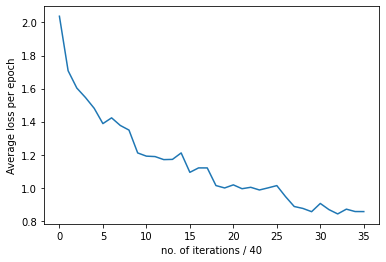

In [24]:
x_values = range(len(loss_list)) 
plt.plot(x_values,loss_list)
plt.xlabel('no. of iterations / 40')
plt.ylabel('Average loss per epoch')
plt.show()

# Predictions and Accuracy

In [65]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 64 %


### Saving Model

In [31]:
PATH = "model.pt"
torch.save(model.state_dict(), PATH)



---



---



# FGSM ATTACK

### Img perturbing fuction

In [52]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Clip the perturbed image to [-1, 1]
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

### Accuracy with varying epison values

In [61]:
# Evaluate the model on test set with FGSM attack
accuracy_list = []
epsilon_list = [0.0, 0.02, 0.04, 0.06, 0.08]


for epsilon in epsilon_list: 
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images.requires_grad = True
        outputs = model(images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        perturbed_images = fgsm_attack(images, epsilon, data_grad)
        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
  
    # Calculate final accuracy for this epsilon
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, accuracy))


Epsilon: 0.0	Test Accuracy = 6439 / 10000 = 64.39
Epsilon: 0.02	Test Accuracy = 1968 / 10000 = 19.68
Epsilon: 0.04	Test Accuracy = 533 / 10000 = 5.33
Epsilon: 0.06	Test Accuracy = 159 / 10000 = 1.59
Epsilon: 0.08	Test Accuracy = 68 / 10000 = 0.68


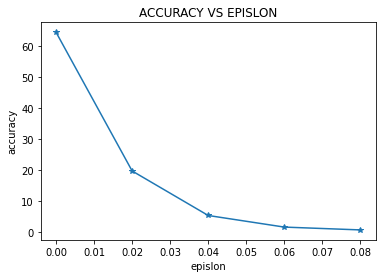

In [62]:
plt.plot(epsilon_list, accuracy_list, '*-')
plt.xlabel('epislon')
plt.ylabel('accuracy')
plt.title('ACCURACY VS EPISLON')
plt.show()



---
THE END

---


